In [50]:
!jupyter nbconvert --to script Assignment1A.ipynb

[NbConvertApp] Converting notebook Assignment1A.ipynb to script
[NbConvertApp] Writing 28506 bytes to Assignment1A.py


In [42]:
#******* Question 1*******#

import pandas as pd
import numpy as np
from math import log2

# Hardcoding the data cuz I'm too lazy to read from a file
data = pd.DataFrame([
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 1, 1],
    [1, 0, 0, 1, 1],
    [0, 1, 1, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 1, 0, 1, 0]
], columns=['x1', 'x2', 'x3', 'x4', 'y'])

# Calculate entropy - pretty standard stuff
def entropy(y):
    if len(y) == 0:
        return 0
    p = y.value_counts() / len(y)
    return -sum(p * np.log2(p))

# Information gain calculation
def info_gain(X, y, feature):
    total_entropy = entropy(y)
    
    weighted_entropy = 0
    for value in X[feature].unique():
        subset_y = y[X[feature] == value]
        weighted_entropy += len(subset_y) / len(y) * entropy(subset_y)
    
    return total_entropy - weighted_entropy

# The main ID3 algorithm - recursion is fun!
def id3(X, y, features, depth=0):
    indent = "  " * depth  # For pretty printing
    print(f"{indent}Entropy: {entropy(y):.4f}")
    
    # Base cases
    if len(y.unique()) == 1 or len(features) == 0:
        return y.mode().iloc[0]
    
    # Calculate info gain for each feature
    gains = {}
    for feature in features:
        gain = info_gain(X, y, feature)
        gains[feature] = gain
        print(f"{indent}Gain for {feature}: {gain:.4f}")
    
    # Pick the best feature
    best_feature = max(gains, key=gains.get)
    print(f"{indent}Splitting on: {best_feature}")
    
    # Build the tree recursively
    tree = {best_feature: {}}
    for value in X[best_feature].unique():
        subset_X = X[X[best_feature] == value].drop(best_feature, axis=1)
        subset_y = y[X[best_feature] == value]
        new_features = [f for f in features if f != best_feature]
        tree[best_feature][value] = id3(subset_X, subset_y, new_features, depth + 1)
    
    return tree

# Convert tree to boolean expression (this part's a bit tricky)
def tree_to_bool(tree):
    def traverse(node, path):
        if isinstance(node, dict):
            feature, branches = next(iter(node.items()))
            exprs = []
            for value, subtree in branches.items():
                new_path = path + [f"{feature}={value}"]
                exprs.extend(traverse(subtree, new_path))
            return exprs
        else:
            return [' AND '.join(path)] if node == 1 else []

    exprs = traverse(tree, [])
    return ' OR '.join(f"({expr})" for expr in exprs)

# Let's run this thing!
print("Building the decision tree:")
print("--------------------------")
X = data.drop('y', axis=1)
y = data['y']
features = X.columns.tolist()
decision_tree = id3(X, y, features)

print("\nBoolean expression (hope this is right):")
print(tree_to_bool(decision_tree))

Building the decision tree:
--------------------------
Entropy: 0.8631
Gain for x1: 0.0617
Gain for x2: 0.4696
Gain for x3: 0.0060
Gain for x4: 0.4696
Splitting on: x2
  Entropy: 0.9183
  Gain for x1: 0.2516
  Gain for x3: 0.2516
  Gain for x4: 0.9183
  Splitting on: x4
    Entropy: -0.0000
    Entropy: -0.0000
  Entropy: -0.0000

Boolean expression (hope this is right):
(x2=0 AND x4=1)


In [26]:
import pandas as pd
from collections import Counter
import io

# Data as a string (CSV format)
data_str = """Outlook,Temperature,Humidity,Wind,Play?
S,H,H,W,-
S,H,H,S,-
O,H,H,W,+
R,M,H,W,+
R,C,N,W,+
R,C,N,S,-
O,C,N,S,+
S,M,H,W,-
S,C,N,W,+
R,M,N,W,+
S,M,N,S,+
O,M,H,S,+
O,H,N,W,+
R,M,H,S,-"""

# Convert string to DataFrame
data = pd.read_csv(io.StringIO(data_str))

def calculate_me(labels):
    count = Counter(labels)
    total = len(labels)
    return min(count['+'] / total, count['-'] / total)

def calculate_attribute_me(data, attribute):
    weighted_me = 0
    total_samples = len(data)
    for value in data[attribute].unique():
        subset = data[data[attribute] == value]
        subset_size = len(subset)
        subset_me = calculate_me(subset['Play?'])
        weighted_me += (subset_size / total_samples) * subset_me
    return weighted_me

def calculate_gain(data, attribute):
    root_me = calculate_me(data['Play?'])
    attr_me = calculate_attribute_me(data, attribute)
    return root_me - attr_me

def print_me_and_gain(data, attributes):
    root_me = calculate_me(data['Play?'])
    print(f"ME(root) = {root_me:.3f}")
    for attr in attributes:
        attr_me = calculate_attribute_me(data, attr)
        gain = root_me - attr_me
        print(f"{attr} (ME) = {attr_me:.3f} (IG) = {gain:.3f}")

def build_tree(data):
    print("First Stage:")
    print_me_and_gain(data, ['Outlook', 'Temperature', 'Humidity', 'Wind'])
    
    print("\nSplit on outlook")
    tree = {'Outlook': {}}
    
    for outlook in data['Outlook'].unique():
        outlook_data = data[data['Outlook'] == outlook]
        if outlook == 'O':
            tree['Outlook'][outlook] = '+'
            print(f"{outlook} = Yes (Leafnote)")
        else:
            print(f"{outlook} = Further Splitting")
            tree['Outlook'][outlook] = {}
    
    print("\nSecond stage (Rainy branch):")
    rainy_data = data[data['Outlook'] == 'R']
    print_me_and_gain(rainy_data, ['Temperature', 'Humidity', 'Wind'])
    
    print("\nSecond stage (Sunny branch):")
    sunny_data = data[data['Outlook'] == 'S']
    print_me_and_gain(sunny_data, ['Temperature', 'Humidity', 'Wind'])
    
    print("\nUnder Rainy Split on Wind")
    tree['Outlook']['R']['Wind'] = {}
    for wind in rainy_data['Wind'].unique():
        wind_data = rainy_data[rainy_data['Wind'] == wind]
        label = '+' if wind == 'W' else '-'
        tree['Outlook']['R']['Wind'][wind] = label
        print(f"{wind} = {'Yes' if label == '+' else 'No'} (Leafnote)")
    
    print("\nUnder Sunny Split on Humidity")
    tree['Outlook']['S']['Humidity'] = {}
    for humidity in sunny_data['Humidity'].unique():
        humidity_data = sunny_data[sunny_data['Humidity'] == humidity]
        label = '+' if humidity == 'N' else '-'
        tree['Outlook']['S']['Humidity'][humidity] = label
        print(f"{humidity} = {'Yes' if label == '+' else 'No'} (Leafnote)")
    
    return tree

print("Question 2a:\n")
decision_tree = build_tree(data)

Question 2a:

First Stage:
ME(root) = 0.357
Outlook (ME) = 0.286 (IG) = 0.071
Temperature (ME) = 0.357 (IG) = 0.000
Humidity (ME) = 0.286 (IG) = 0.071
Wind (ME) = 0.357 (IG) = 0.000

Split on outlook
S = Further Splitting
O = Yes (Leafnote)
R = Further Splitting

Second stage (Rainy branch):
ME(root) = 0.400
Temperature (ME) = 0.400 (IG) = 0.000
Humidity (ME) = 0.400 (IG) = 0.000
Wind (ME) = 0.000 (IG) = 0.400

Second stage (Sunny branch):
ME(root) = 0.400
Temperature (ME) = 0.200 (IG) = 0.200
Humidity (ME) = 0.000 (IG) = 0.400
Wind (ME) = 0.400 (IG) = 0.000

Under Rainy Split on Wind
W = Yes (Leafnote)
S = No (Leafnote)

Under Sunny Split on Humidity
H = No (Leafnote)
N = Yes (Leafnote)


In [28]:
import pandas as pd
from collections import Counter
import io

# Data as a string (CSV format)
data_str = """Outlook,Temperature,Humidity,Wind,Play?
S,H,H,W,-
S,H,H,S,-
O,H,H,W,+
R,M,H,W,+
R,C,N,W,+
R,C,N,S,-
O,C,N,S,+
S,M,H,W,-
S,C,N,W,+
R,M,N,W,+
S,M,N,S,+
O,M,H,S,+
O,H,N,W,+
R,M,H,S,-"""

# Convert string to DataFrame
data = pd.read_csv(io.StringIO(data_str))

def calculate_gini(labels):
    count = Counter(labels)
    total = len(labels)
    return 1 - sum((count[label] / total) ** 2 for label in count)

def calculate_attribute_gini(data, attribute):
    weighted_gini = 0
    total_samples = len(data)
    for value in data[attribute].unique():
        subset = data[data[attribute] == value]
        subset_size = len(subset)
        subset_gini = calculate_gini(subset['Play?'])
        weighted_gini += (subset_size / total_samples) * subset_gini
    return weighted_gini

def calculate_gain(data, attribute):
    root_gini = calculate_gini(data['Play?'])
    attr_gini = calculate_attribute_gini(data, attribute)
    return root_gini - attr_gini

def print_gini_and_gain(data, attributes):
    root_gini = calculate_gini(data['Play?'])
    print(f"Gini(root) = {root_gini:.3f}")
    for attr in attributes:
        attr_gini = calculate_attribute_gini(data, attr)
        gain = root_gini - attr_gini
        print(f"{attr} (Gini) = {attr_gini:.3f} (IG) = {gain:.3f}")

def build_tree(data):
    print("First Stage:")
    print_gini_and_gain(data, ['Outlook', 'Temperature', 'Humidity', 'Wind'])
    
    print("\nSplit on outlook")
    tree = {'Outlook': {}}
    
    for outlook in data['Outlook'].unique():
        outlook_data = data[data['Outlook'] == outlook]
        if outlook == 'O':
            tree['Outlook'][outlook] = '+'
            print(f"{outlook} = Yes (Leafnote)")
        else:
            print(f"{outlook} = Further Splitting")
            tree['Outlook'][outlook] = {}
    
    print("\nSecond stage (Rainy branch):")
    rainy_data = data[data['Outlook'] == 'R']
    print_gini_and_gain(rainy_data, ['Temperature', 'Humidity', 'Wind'])
    
    print("\nSecond stage (Sunny branch):")
    sunny_data = data[data['Outlook'] == 'S']
    print_gini_and_gain(sunny_data, ['Temperature', 'Humidity', 'Wind'])
    
    print("\nUnder Rainy Split on Wind")
    tree['Outlook']['R']['Wind'] = {}
    for wind in rainy_data['Wind'].unique():
        wind_data = rainy_data[rainy_data['Wind'] == wind]
        label = '+' if wind == 'W' else '-'
        tree['Outlook']['R']['Wind'][wind] = label
        print(f"{wind} = {'Yes' if label == '+' else 'No'} (Leafnote)")
    
    print("\nUnder Sunny Split on Humidity")
    tree['Outlook']['S']['Humidity'] = {}
    for humidity in sunny_data['Humidity'].unique():
        humidity_data = sunny_data[sunny_data['Humidity'] == humidity]
        label = '+' if humidity == 'N' else '-'
        tree['Outlook']['S']['Humidity'][humidity] = label
        print(f"{humidity} = {'Yes' if label == '+' else 'No'} (Leafnote)")
    
    return tree

print("Question 2b:\n")
decision_tree = build_tree(data)

Question 2b:

First Stage:
Gini(root) = 0.459
Outlook (Gini) = 0.343 (IG) = 0.116
Temperature (Gini) = 0.440 (IG) = 0.019
Humidity (Gini) = 0.367 (IG) = 0.092
Wind (Gini) = 0.429 (IG) = 0.031

Split on outlook
S = Further Splitting
O = Yes (Leafnote)
R = Further Splitting

Second stage (Rainy branch):
Gini(root) = 0.480
Temperature (Gini) = 0.467 (IG) = 0.013
Humidity (Gini) = 0.467 (IG) = 0.013
Wind (Gini) = 0.000 (IG) = 0.480

Second stage (Sunny branch):
Gini(root) = 0.480
Temperature (Gini) = 0.200 (IG) = 0.280
Humidity (Gini) = 0.000 (IG) = 0.480
Wind (Gini) = 0.467 (IG) = 0.013

Under Rainy Split on Wind
W = Yes (Leafnote)
S = No (Leafnote)

Under Sunny Split on Humidity
H = No (Leafnote)
N = Yes (Leafnote)


In [48]:
#**********Question 3(a)**********#

# I used the most common attribute in this dataset "rainy" because comparing with other attributes and following the trends rainy fits best 
# and has the most likelyhood of occuring. 

#**********Question 3(b)**********#

# The most common value among the training instance with the same label their play attribute is yes is "rainy" because because it has 3 yes and 2 no as
# compared to sunny with 2 yes and 3 no. 

import pandas as pd
import math
from collections import Counter
import io

def entropy(labels):
    """Calculate entropy of the given labels."""
    label_counts = Counter(labels)
    total = len(labels)
    return -sum((count / total) * math.log2(count / total) for count in label_counts.values())

def attribute_entropy(data, attr):
    """Calculate weighted entropy for a given attribute."""
    total = len(data)
    return sum(
        len(subset) / total * entropy(subset['Play?'])
        for _, subset in data.groupby(attr)
    )

def info_gain(data, attr):
    """Calculate information gain for an attribute."""
    return entropy(data['Play?']) - attribute_entropy(data, attr)

def print_entropy_and_gain(data, attrs):
    """Print entropy and information gain for given attributes."""
    root_entropy = entropy(data['Play?'])
    print(f"Root entropy: {root_entropy:.3f}")
    
    for attr in attrs:
        attr_entropy = attribute_entropy(data, attr)
        gain = root_entropy - attr_entropy
        print(f"{attr:12} Entropy: {attr_entropy:.3f}  Info Gain: {gain:.3f}")

def build_decision_tree(data):
    """Build and print the decision tree."""
    print("First Stage:")
    print_entropy_and_gain(data, ['Outlook', 'Temperature', 'Humidity', 'Wind'])
    
    tree = {'Outlook': {}}
    print("\nSplitting on Outlook")
    
    for outlook in data['Outlook'].unique():
        outlook_data = data[data['Outlook'] == outlook]
        if outlook == 'O':
            tree['Outlook'][outlook] = '+'
            print(f"  {outlook}: Yes (Leaf node)")
        else:
            print(f"  {outlook}: Needs further splitting")
            tree['Outlook'][outlook] = {}
    
    print("\nSecond stage - Rainy branch:")
    rainy_data = data[data['Outlook'] == 'R']
    print_entropy_and_gain(rainy_data, ['Temperature', 'Humidity', 'Wind'])
    
    print("\nSecond stage - Sunny branch:")
    sunny_data = data[data['Outlook'] == 'S']
    print_entropy_and_gain(sunny_data, ['Temperature', 'Humidity', 'Wind'])
    
    # Handle Rainy branch
    print("\nRainy branch - Splitting on Wind")
    tree['Outlook']['R'] = {'Wind': {}}
    for wind in rainy_data['Wind'].unique():
        decision = '+' if wind == 'W' else '-'
        tree['Outlook']['R']['Wind'][wind] = decision
        print(f"  Wind {wind}: {'Yes' if decision == '+' else 'No'} (Leaf node)")
    
    # Handle Sunny branch
    print("\nSunny branch - Splitting on Humidity")
    tree['Outlook']['S'] = {'Humidity': {}}
    for humidity in sunny_data['Humidity'].unique():
        decision = '+' if humidity == 'N' else '-'
        tree['Outlook']['S']['Humidity'][humidity] = decision
        print(f"  Humidity {humidity}: {'Yes' if decision == '+' else 'No'} (Leaf node)")
    
    return tree

# Data preparation
raw_data = ''',Outlook,Temperature,Humidity,Wind,Play?
1,S,H,H,W,-
2,S,H,H,S,-
3,O,H,H,W,+
4,R,M,H,W,+
5,R,C,N,W,+
6,R,C,N,S,-
7,O,C,N,S,+
8,S,M,H,W,-
9,S,C,N,W,+
10,R,M,N,W,+
11,S,M,N,S,+
12,O,M,H,S,+
13,O,H,N,W,+
14,R,M,H,S,-
15,R,M,N,W,+'''

# Main execution
if __name__ == "__main__":
    print("Question 3a \n")
    df = pd.read_csv(io.StringIO(raw_data))
    tree = build_decision_tree(df)

Question 3a 

First Stage:
Root entropy: 0.918
Outlook      Entropy: 0.691  Info Gain: 0.227
Temperature  Entropy: 0.886  Info Gain: 0.032
Humidity     Entropy: 0.750  Info Gain: 0.169
Wind         Entropy: 0.859  Info Gain: 0.060

Splitting on Outlook
  S: Needs further splitting
  O: Yes (Leaf node)
  R: Needs further splitting

Second stage - Rainy branch:
Root entropy: 0.918
Temperature  Entropy: 0.874  Info Gain: 0.044
Humidity     Entropy: 0.874  Info Gain: 0.044
Wind         Entropy: 0.000  Info Gain: 0.918

Second stage - Sunny branch:
Root entropy: 0.971
Temperature  Entropy: 0.400  Info Gain: 0.571
Humidity     Entropy: 0.000  Info Gain: 0.971
Wind         Entropy: 0.951  Info Gain: 0.020

Rainy branch - Splitting on Wind
  Wind W: Yes (Leaf node)
  Wind S: No (Leaf node)

Sunny branch - Splitting on Humidity
  Humidity H: No (Leaf node)
  Humidity N: Yes (Leaf node)


In [20]:
#**********Question 3(c)**********#

import pandas as pd
import numpy as np
from collections import Counter

def entropy(probabilities):
    return -sum(p * np.log2(p) if p > 0 else 0 for p in probabilities)

def cal_feaE_and_IG(data, feature):
    feature_counts = Counter(data[feature].dropna())
    total_known = sum(feature_counts.values())
    
    fractional_counts = {k: v / total_known for k, v in feature_counts.items()} if data[feature].isnull().any() else {}
    
    new_counts = {k: v + fractional_counts.get(k, 0) for k, v in feature_counts.items()}
    
    total_instances = len(data)
    P_count = sum(data['Play?'] == '+')
    N_count = total_instances - P_count
    total_entropy = entropy([P_count/total_instances, N_count/total_instances])
    
    weighted_entropy = 0
    for value, count in new_counts.items():
        subset = data[data[feature] == value]
        subset_positive = sum(subset['Play?'] == '+')
        subset_negative = len(subset) - subset_positive
        
        if value in fractional_counts:
            subset_positive += fractional_counts[value] * (P_count / total_instances)
            subset_negative += fractional_counts[value] * (N_count / total_instances)
        
        subset_entropy = entropy([subset_positive/count, subset_negative/count])
        weighted_entropy += (count / total_instances) * subset_entropy
    
    information_gain = total_entropy - weighted_entropy
    
    return weighted_entropy, information_gain

path_f = r'C:\Users\Jeremiah\OneDrive - University of Utah\Desktop\Fall 2024\Machine Learning\Github\Machine-Learning\Homework 1\Q3C.csv'
data = pd.read_csv(path_f, index_col=0)

features = ['Outlook', 'Temperature', 'Humidity', 'Wind']

total_instances = len(data)
P_count = sum(data['Play?'] == '+')
N_count = total_instances - P_count
root_entropy = entropy([P_count/total_instances, N_count/total_instances])

print("First Stage:")
print(f"Entropy(root) = {root_entropy:.3f}")

infor_gains = {}

for feature in features:
    feature_entropy, ig = cal_feaE_and_IG(data, feature)
    print(f"{feature} (Entropy) = {feature_entropy:.3f} (IG) = {ig:.3f}")
    infor_gains[feature] = ig

root_attribute = max(infor_gains, key=infor_gains.get)
print(f"\nAttribute selected for root: {root_attribute}")

def cal_sub_entropy(subset):
    if len(subset) == 0:
        return 0
    P_count = sum(subset['Play?'] == '+')
    N_count = len(subset) - P_count
    total_count = len(subset)
    return entropy([P_count/total_count, N_count/total_count])

print("\nSecond Stage:")
for value in data[root_attribute].unique():
    if pd.isna(value):
        continue  
    subset = data[data[root_attribute] == value]
    subset_entropy = cal_sub_entropy(subset)
    print(f"{root_attribute} = {value}:")
    print(f"Entropy = {subset_entropy:.3f}")
    
    remaining_features = [f for f in features if f != root_attribute]
    for feature in remaining_features:
        _, ig = cal_feaE_and_IG(subset, feature)
        print(f"  {feature} (IG) = {ig:.3f}")
    print()

First Stage:
Entropy(root) = 0.918
Outlook (Entropy) = 0.740 (IG) = 0.178
Temperature (Entropy) = 0.886 (IG) = 0.032
Humidity (Entropy) = 0.750 (IG) = 0.169
Wind (Entropy) = 0.859 (IG) = 0.060

Attribute selected for root: Outlook

Second Stage:
Outlook = S:
Entropy = 0.971
  Temperature (IG) = 0.571
  Humidity (IG) = 0.971
  Wind (IG) = 0.020

Outlook = O:
Entropy = -0.000
  Temperature (IG) = -0.000
  Humidity (IG) = -0.000
  Wind (IG) = -0.000

Outlook = R:
Entropy = 0.971
  Temperature (IG) = 0.020
  Humidity (IG) = 0.020
  Wind (IG) = 0.971



In [30]:
#********Session 2 Question 2*******#

import csv
from collections import defaultdict
import math
import os

base_path = r'C:\Users\Jeremiah\Desktop\Q2'
train_file = os.path.join(base_path, 'train.csv')
test_file = os.path.join(base_path, 'test.csv')
desc_file = os.path.join(base_path, 'data-desc.txt')

def cal_entropy(data):
    labels = [row[-1] for row in data]
    label_counts = defaultdict(int)
    for label in labels:
        label_counts[label] += 1
    entropy = 0
    for count in label_counts.values():
        prob = count / len(labels)
        entropy -= prob * math.log2(prob)
    return entropy

def cal_infor_gain(data, attribute_index):
    base_entropy = cal_entropy(data)
    attribute_values = set(row[attribute_index] for row in data)
    weighted_entropy = 0
    for value in attribute_values:
        subset = [row for row in data if row[attribute_index] == value]
        weight = len(subset) / len(data)
        weighted_entropy += weight * cal_entropy(subset)
    return base_entropy - weighted_entropy

def cal_maj_error(data):
    labels = [row[-1] for row in data]
    label_counts = defaultdict(int)
    for label in labels:
        label_counts[label] += 1
    majority_count = max(label_counts.values())
    return 1 - majority_count / len(labels)

def cal_gini_index(data):
    labels = [row[-1] for row in data]
    label_counts = defaultdict(int)
    for label in labels:
        label_counts[label] += 1
    gini = 1
    for count in label_counts.values():
        prob = count / len(labels)
        gini -= prob ** 2
    return gini

def ch_best_attribute(data, attributes, criterion):
    if criterion == 'information_gain':
        gains = [cal_infor_gain(data, i) for i in range(len(attributes))]
        return attributes[gains.index(max(gains))]
    elif criterion == 'majority_error':
        errors = []
        for i in range(len(attributes)):
            values = set(row[i] for row in data)
            error = 0
            for value in values:
                subset = [row for row in data if row[i] == value]
                error += cal_maj_error(subset)
            errors.append(error)
        return attributes[errors.index(min(errors))]
    elif criterion == 'gini_index':
        ginis = []
        for i in range(len(attributes)):
            values = set(row[i] for row in data)
            gini = 0
            for value in values:
                subset = [row for row in data if row[i] == value]
                gini += cal_gini_index(subset)
            ginis.append(gini)
        return attributes[ginis.index(min(ginis))]


def id3(data, attributes, criterion, M_depth, C_depth=0):
    labels = [row[-1] for row in data]
    if len(set(labels)) == 1:
        return labels[0]
    if not attributes or C_depth == M_depth:
        return max(set(labels), key=labels.count)
    
    best_attribute = ch_best_attribute(data, attributes, criterion)
    tree = {best_attribute: {}}
    
    for value in set(row[attributes.index(best_attribute)] for row in data):
        subset = [row for row in data if row[attributes.index(best_attribute)] == value]
        if not subset:
            tree[best_attribute][value] = max(set(labels), key=labels.count)
        else:
            N_att = [attr for attr in attributes if attr != best_attribute]
            tree[best_attribute][value] = id3(subset, N_att, criterion, M_depth, C_depth + 1)
    
    return tree


def predict(tree, instance, default_label=None):
    if not isinstance(tree, dict):
        return tree
    attribute = list(tree.keys())[0]
    value = instance.get(attribute) 
    
    if value not in tree[attribute]:
        return default_label
    
    return predict(tree[attribute][value], instance, default_label)


def evaluate(tree, data, default_label):
    if not data:
        print("Error: No data to evaluate.")
        return 0
    correct = 0
    for instance in data:
        if predict(tree, dict(zip(attributes, instance[:-1])), default_label) == instance[-1]:
            correct += 1
    return correct / len(data)


if __name__ == "__main__":
    train_data = read_csv(train_file)
    test_data = read_csv(test_file)

    attributes = train_data[0][:-1]  
    train_data = train_data[1:]
    test_data = test_data[1:]

    print(f"Num of attributes: {len(attributes)}")
    print(f"Attributes: {attributes}")

    criteria = ['information_gain', 'majority_error', 'gini_index']
    max_depths = range(1, 7)

    results = {criterion: {'train': [], 'test': []} for criterion in criteria}

    for criterion in criteria:
        for depth in max_depths:
            tree = id3(train_data, attributes, criterion, depth)
            labels = [row[-1] for row in train_data]
            default_label = max(set(labels), key=labels.count) 
            
            train_accuracy = evaluate(tree, train_data, default_label)
            test_accuracy = evaluate(tree, test_data, default_label)
            
            results[criterion]['train'].append(1 - train_accuracy)
            results[criterion]['test'].append(1 - test_accuracy)

    
    print("\nError rates:")
    print("Depth | Information Gain | Majority Error | Gini Index")
    print("      | Train   | Test   | Train   | Test  | Train  | Test")
    for depth in max_depths:
        print(f"{depth:5d} | {results['information_gain']['train'][depth-1]:.4f} | {results['information_gain']['test'][depth-1]:.4f} | "
              f"{results['majority_error']['train'][depth-1]:.4f} | {results['majority_error']['test'][depth-1]:.4f} | "
              f"{results['gini_index']['train'][depth-1]:.4f} | {results['gini_index']['test'][depth-1]:.4f}")

# Print (" The training error is consistent while the test error increases gradually.")

Num of attributes: 6
Attributes: ['low', 'vhigh', '4', '4', 'big', 'med']

Error rates:
Depth | Information Gain | Majority Error | Gini Index
      | Train   | Test   | Train   | Test  | Train  | Test
    1 | 0.3013 | 0.2971 | 0.3013 | 0.2971 | 0.3013 | 0.2971
    2 | 0.3013 | 0.2971 | 0.3013 | 0.2971 | 0.3013 | 0.2971
    3 | 0.2933 | 0.3012 | 0.3013 | 0.2971 | 0.3013 | 0.2971
    4 | 0.3303 | 0.3260 | 0.3013 | 0.2971 | 0.3013 | 0.2971
    5 | 0.3053 | 0.3054 | 0.3013 | 0.2971 | 0.3013 | 0.2971
    6 | 0.3053 | 0.3054 | 0.3013 | 0.2971 | 0.3013 | 0.2971


Num of attributes: 16
Attributes: ['41', 'services', 'married', 'secondary', 'no', '0', 'yes', 'no', 'unknown', '5', 'may', '114', '2', '-1', '0', 'unknown']

Error rates:
Depth | Information Gain | Majority Error | Gini Index
      | Train   | Test   | Train   | Test  | Train  | Test
    1 | 0.0782 | 0.1308 | 0.1192 | 0.1248 | 0.1192 | 0.1248
    2 | 0.0108 | 0.1522 | 0.1192 | 0.1248 | 0.1192 | 0.1248
    3 | 0.0058 | 0.1526 | 0.1192 | 0.1248 | 0.1192 | 0.1248
    4 | 0.0058 | 0.1526 | 0.1192 | 0.1248 | 0.1192 | 0.1248
    5 | 0.0058 | 0.1526 | 0.1192 | 0.1248 | 0.1192 | 0.1248
    6 | 0.0058 | 0.1526 | 0.1192 | 0.1248 | 0.1192 | 0.1248
    7 | 0.0058 | 0.1526 | 0.1192 | 0.1248 | 0.1192 | 0.1248
    8 | 0.0058 | 0.1526 | 0.1192 | 0.1248 | 0.1192 | 0.1248
    9 | 0.0058 | 0.1526 | 0.1192 | 0.1248 | 0.1192 | 0.1248
   10 | 0.0058 | 0.1526 | 0.1192 | 0.1248 | 0.1192 | 0.1248
   11 | 0.0058 | 0.1526 | 0.1192 | 0.1248 | 0.1192 | 0.1248
   12 | 0.0058 | 0.1526 | 0.1192 | 0.1248 | 0.1192 | 0

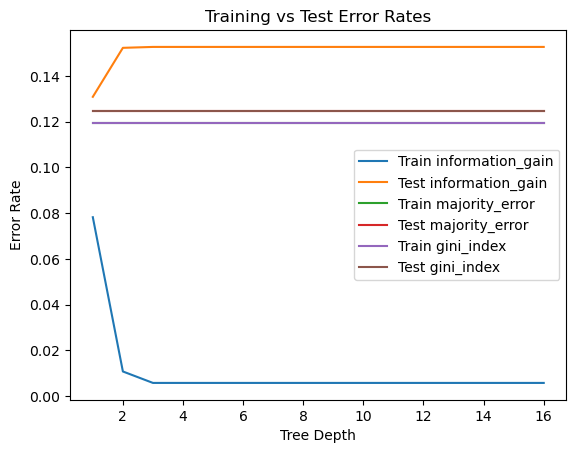

In [12]:
#********Session 2 Question 3*******#

import csv
from collections import defaultdict
import math
import os
import statistics
import matplotlib.pyplot as plt

base_path = r'C:\Users\Jeremiah\Desktop\bank'
train_file = os.path.join(base_path, 'train.csv')
test_file = os.path.join(base_path, 'test.csv')
desc_file = os.path.join(base_path, 'data-desc.txt')

def preprocess_data(data, numerical_indices):
    medians = {}
    for index in numerical_indices:
        numerical_values = []
        for row in data:
            value = row[index]
            if value != 'unknown' and value.replace('.', '', 1).isdigit():
                numerical_values.append(float(value))
        
        if numerical_values:  
            medians[index] = statistics.median(numerical_values)
        else:
            medians[index] = 0  
        
    for row in data:
        for index in numerical_indices:
            if row[index] != 'unknown' and row[index].replace('.', '', 1).isdigit():
                row[index] = '1' if float(row[index]) > medians[index] else '0'
    
    return data

def cal_entropy(data):
    labels = [row[-1] for row in data]
    label_counts = defaultdict(int)
    for label in labels:
        label_counts[label] += 1
    entropy = 0
    for count in label_counts.values():
        prob = count / len(labels)
        entropy -= prob * math.log2(prob)
    return entropy

def cal_infor_gain(data, attribute_index):
    base_entropy = cal_entropy(data)
    attribute_values = set(row[attribute_index] for row in data)
    weighted_entropy = 0
    for value in attribute_values:
        subset = [row for row in data if row[attribute_index] == value]
        weight = len(subset) / len(data)
        weighted_entropy += weight * cal_entropy(subset)
    return base_entropy - weighted_entropy

def cal_maj_error(data):
    labels = [row[-1] for row in data]
    label_counts = defaultdict(int)
    for label in labels:
        label_counts[label] += 1
    majority_count = max(label_counts.values())
    return 1 - majority_count / len(labels)


def cal_gini_index(data):
    labels = [row[-1] for row in data]
    label_counts = defaultdict(int)
    for label in labels:
        label_counts[label] += 1
    gini = 1
    for count in label_counts.values():
        prob = count / len(labels)
        gini -= prob ** 2
    return gini


def ch_best_attribute(data, attributes, criterion):
    if criterion == 'information_gain':
        gains = [cal_infor_gain(data, i) for i in range(len(attributes))]
        return attributes[gains.index(max(gains))]
    elif criterion == 'majority_error':
        errors = []
        for i in range(len(attributes)):
            values = set(row[i] for row in data)
            error = 0
            for value in values:
                subset = [row for row in data if row[i] == value]
                error += cal_maj_error(subset)
            errors.append(error)
        return attributes[errors.index(min(errors))]
    elif criterion == 'gini_index':
        ginis = []
        for i in range(len(attributes)):
            values = set(row[i] for row in data)
            gini = 0
            for value in values:
                subset = [row for row in data if row[i] == value]
                gini += cal_gini_index(subset)
            ginis.append(gini)
        return attributes[ginis.index(min(ginis))]

def id3(data, attributes, criterion, max_depth, current_depth=0):
    labels = [row[-1] for row in data]
    if len(set(labels)) == 1:
        return labels[0]
    if not attributes or current_depth == max_depth:
        return max(set(labels), key=labels.count)
    
    best_attribute = ch_best_attribute(data, attributes, criterion)
    tree = {best_attribute: {}}
    
    for value in set(row[attributes.index(best_attribute)] for row in data):
        subset = [row for row in data if row[attributes.index(best_attribute)] == value]
        if not subset:
            tree[best_attribute][value] = max(set(labels), key=labels.count)
        else:
            new_attributes = [attr for attr in attributes if attr != best_attribute]
            tree[best_attribute][value] = id3(subset, new_attributes, criterion, max_depth, current_depth + 1)
    
    return tree

def predict(tree, instance, default_label=None):
    if not isinstance(tree, dict):
        return tree
    attribute = list(tree.keys())[0]
    value = instance.get(attribute) 
    
    if value not in tree[attribute]:
        return default_label
    
    return predict(tree[attribute][value], instance, default_label)

def evaluate(tree, data, default_label):
    if not data:
        print("Error: No data to evaluate.")
        return 0
    correct = 0
    for instance in data:
        if predict(tree, dict(zip(attributes, instance[:-1])), default_label) == instance[-1]:
            correct += 1
    return correct / len(data)


if __name__ == "__main__":
    train_data = read_csv(train_file)
    test_data = read_csv(test_file)

    if not train_data or not test_data:
        print("Error data. Exiting.")
        exit(1)

    attributes = train_data[0][:-1]  
    train_data = train_data[1:]
    test_data = test_data[1:]

   
    numerical_indices = [0, 5, 12, 13, 14, 15]  
    train_data = preprocess_data(train_data, numerical_indices)
    test_data = preprocess_data(test_data, numerical_indices)

    print(f"Num of attributes: {len(attributes)}")
    print(f"Attributes: {attributes}")

  
    criteria = ['information_gain', 'majority_error', 'gini_index']
    max_depths = range(1, 17)

    results = {criterion: {'train': [], 'test': []} for criterion in criteria}

    for criterion in criteria:
        for depth in max_depths:
            tree = id3(train_data, attributes, criterion, depth)
            labels = [row[-1] for row in train_data]
            default_label = max(set(labels), key=labels.count) 
            
            train_accuracy = evaluate(tree, train_data, default_label)
            test_accuracy = evaluate(tree, test_data, default_label)
            
            results[criterion]['train'].append(1 - train_accuracy)
            results[criterion]['test'].append(1 - test_accuracy)

    print("\nError rates:")
    print("Depth | Information Gain | Majority Error | Gini Index")
    print("      | Train   | Test   | Train   | Test  | Train  | Test")
    for depth in max_depths:
        print(f"{depth:5d} | {results['information_gain']['train'][depth-1]:.4f} | {results['information_gain']['test'][depth-1]:.4f} | "
              f"{results['majority_error']['train'][depth-1]:.4f} | {results['majority_error']['test'][depth-1]:.4f} | "
              f"{results['gini_index']['train'][depth-1]:.4f} | {results['gini_index']['test'][depth-1]:.4f}")


    for criterion in criteria:
        plt.plot(max_depths, results[criterion]['train'], label=f'Train {criterion}')
        plt.plot(max_depths, results[criterion]['test'], label=f'Test {criterion}')
    
    plt.xlabel('Tree Depth')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.title('Training vs Test Error Rates')
    plt.show()